## Problem statement

$$ \frac{\partial }{\partial x*} \left(  ( 1 + \epsilon_c \theta )  \frac{\partial \theta }{\partial x*} \right)   - N^2 \theta + N^2 G ( 1 + \epsilon_G \theta ) = 0   $$ 

#### Where: 

- $\theta(x) = \dfrac{T(x) - T_\inf}{T_{b} - T_{\inf}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_\inf)}$


- $\epsilon_G=\epsilon(T_b-T_\inf)$


- $\epsilon_C=\beta(T_b-T_\inf)$

#### and the boundary conditions are:

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$


**Given a sample which contains 9 values of $x$ and $\theta$ predict $G$** 

## Import libraries 

In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.ticker
# from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io

## Set random seed and select device

In [2]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda': 
    print(torch.cuda.get_device_name())
    
device = 'cpu'
print('Devuce employed:', device)

Devuce employed: cpu


## Load data

In [3]:
## Load dataset
relative_csv_path = "./../src/data/raw/Dataset.csv"
split_ratio = 0.2

# Load a random sample
fields_G = ['G']
fields_T = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
fields = fields_T + fields_G
df_T = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
random_sample = df_T.sample()
G_real = random_sample[fields_G].to_numpy()
T_real = random_sample[fields_T].to_numpy()
X_real = np.linspace(0,1,T_real.shape[1]).reshape(-1,1)
X_real = X_real.astype(np.float32)

# compute theta 
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K
Theta_real = np.multiply(np.add(T_real, [-T_inf]), [1/(T_b - T_inf)]).T
Theta_real = Theta_real.astype(np.float32)
Theta_real = torch.from_numpy(Theta_real)
# prin shapes 
print('Theta real shape is:',Theta_real.shape)
print('X real shape is:',X_real.shape)
print('G_real is:',G_real)

# lower and uper bounds to normalize the input of net U
lb = min(X_real)
ub = max(X_real)
print('lb is %.2f and ub is %.2f' % (lb,ub))
N_u = Theta_real.shape[0]
print("The number real points are", N_u)
print(X_real.dtype)
print(Theta_real.dtype)

Theta real shape is: torch.Size([9, 1])
X real shape is: (9, 1)
G_real is: [[0.70303543]]
lb is 0.00 and ub is 1.00
The number real points are 9
float32
torch.float32


### Collocation points ($loss_f$)

In [4]:
N_f = 9 #Total number of collocation points 
f_hat = torch.zeros(N_f,1).to(device)
print("The number of collocation points are", N_f)
offset = .0001
X_train_f = torch.linspace(lb[0] + offset,ub[0] - offset,N_f).reshape(-1,1)

The number of collocation points are 9


## Model hyper parameters

In [5]:
steps = 10000
lr = 1e-4
input_dim = X_real.shape[1]
output_dim = Theta_real.shape[1]
layers = np.array([input_dim,20,20,20,20,20,20,20,20,output_dim]) #number of neurons for each layer
print("The number of layers selected are", layers.size)

The number of layers selected are 10


## Deep NN class

In [6]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        # inpunt and hidden layers forward computation
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

## PINN class

In [15]:
class PINN():
    def __init__(self, layers):
        
        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialize iterator'
        self.iter = 0
        
        'Initialize our new parameter G, N, ec, eg as tensor (Inverse problem)' 
        self.G = torch.tensor([float(G)], requires_grad=True).float().to(device)  
        self.N = torch.tensor([float(N)], requires_grad=True).float().to(device)  
        self.ec = torch.tensor([float(ec)], requires_grad=True).float().to(device)  
        self.eg = torch.tensor([float(eg)], requires_grad=True).float().to(device)  

                
        'Register parametes to be optimized'
        self.G = nn.Parameter(self.G)
        self.N= nn.Parameter(self.N)
        self.ec= nn.Parameter(self.ec)
        self.eg= nn.Parameter(self.eg)

        'Initialize our DNN'
        self.dnn = DNN(layers).to(device)
        
        'Register our new parameter'
        self.dnn.register_parameter('G', self.G)  
        self.dnn.register_parameter('N', self.N)  
        self.dnn.register_parameter('ec', self.ec)  
        self.dnn.register_parameter('eg', self.eg)  

    def loss_data(self,x,u):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)
            
        if torch.is_tensor(u) != True:         
            u = torch.from_numpy(u)               
        
        loss_u = self.loss_function(self.dnn(x), u)
        
        return loss_u
        
    def loss_PDE(self, X_train_f):
        
        if torch.is_tensor(X_train_f) != True:         
            X_train_f = torch.from_numpy(X_train_f)     
                   
        # extract the PDE parameters
        G = self.G
        N = self.N
        ec = self.ec
        eg = self.eg

        # clone the input data and add AD
        x = X_train_f.clone()
        x.requires_grad = True
        
        # predict theta
        theta = self.dnn(x)

        # compute derivatives 
        theta_x = autograd.grad(theta, x, torch.ones([X_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        # copmute term to be derived
        aux = (1 + ec * theta) * theta_x
        
        aux_x = autograd.grad(aux, x, torch.ones(X_train_f.shape).to(device), create_graph=True)[0]
                
        # PDE f  = 0
        f = aux_x - N**2 * theta + N**2 * G * (1 + eg * theta)   

        # f_hat is just an auxiliar term to copmute the loss (is zero)
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,x_u,u,x_f):

        loss_u = self.loss_data(x_u, u)
        loss_f = self.loss_PDE(x_f)
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
#     'callable for optimizer'                                       
#     def closure(self):
        
#         optimizer.zero_grad()
        
#         loss = self.loss(X_real, Theta_real, X_train_f)
        
#         loss.backward()
                
#         self.iter += 1
        
#         print(
#             'Loss error(Train): %.5f , G_real = [%.5f], G_PINN = [%.5f]' %
#             (
#                 loss.cpu().detach().numpy(),
#                 G_real,
#                 self.G.item(),
#             )
#         )
                

#         return loss        
    
    'foward pass'
    def forward(self,x):
        return self.dnn(x)
    
    'test neural network'
    def test(self):
                
        theta_pred = self.dnn(X_real)
        
        error_vec = torch.linalg.norm((Theta_real - theta_pred),2)/torch.linalg.norm(Theta_real,2)        # Relative L2 Norm of the error (Vector)
        
        theta_pred = theta_pred.cpu().detach().numpy()
                        
        return error_vec, theta_pred

In [8]:
G = .5
N = 2
ec = .4
eg = .2
print("Te real G = [",G_real,"]. Our initial guess will be G_PINN= [",G,"]")
print("Our initial of the other params are: \n N  = [",N,"]\n eg = [",eg,"] \n ec = [",ec,"]")

Te real G = [ [[0.70303543]] ]. Our initial guess will be G_PINN= [ 0.5 ]
Our initial of the other params are: 
 N  = [ 2 ]
 eg = [ 0.2 ] 
 ec = [ 0.4 ]


## Train the model


In [16]:
'Neural Network Summary'
pinn = PINN(layers)
print(pinn.dnn)

'Neural Network Parameters'
params = list(pinn.dnn.parameters())

'L-BFGS Optimizer'
optimizer = torch.optim.Adam(params, lr, 
                             amsgrad = True)
#                               max_iter = steps, 
#                               max_eval = None, 
#                               tolerance_grad = 1e-11, 
#                               tolerance_change = 1e-15, 
#                               history_size = 100, 
#                               line_search_fn = 'strong_wolfe')
# 'Test loss u methods'
# y_nn =pinn.dnn(X_real)
# loss_theta_manufacuted = pinn.loss_function(y_nn, Theta_real)
# print(loss_theta_manufacuted)
# loss_theta = pinn.loss_data(X_real, Theta_real)
# print(loss_theta)
# assert(loss_theta_manufacuted == loss_theta)

# 'Test loss f methods'
# loss_pde = pinn.loss_PDE(X_train_f)

# 'Test overeall loss'
# loss_manufactured = loss_pde + loss_theta
# overall_loss = pinn.loss(X_real, Theta_real, X_train_f)
# print(loss_manufactured.to_numpy())
# print(overall_loss)
# assert(loss_theta_manufacuted == overall_loss)


# # start_time = time.time()
# 'Test Optimizer step'
# optimizer.zero_grad()

# loss = pinn.loss(X_real, Theta_real, X_train_f)
# print(loss)
# loss.backward()
# loss_after_backawrd = pinn.closure()
# print(loss_after_backawrd)
# assert(loss_after_backawrd == loss)


'Store losses and predicted G values'
loss_theta = np.zeros((steps,))
loss_f = np.zeros((steps,))
loss_hist = np.zeros((steps,))
G_hist = np.zeros((steps,))
N_hist = np.zeros((steps,))
ec_hist = np.zeros((steps,))
eg_hist = np.zeros((steps,))


'Train the model'
for epoch in range(steps):
    # compute net U prediction
    theta_nn = pinn.dnn(X_real)
    # compute losses
    loss_theta[epoch] = pinn.loss_data(X_real, Theta_real).to('cpu').detach().numpy()
    loss_f[epoch] = pinn.loss_PDE(X_train_f).to('cpu').detach().numpy()
    loss = pinn.loss(X_real, Theta_real, X_train_f)
    loss_hist[epoch] = loss.to('cpu').detach().numpy()
    # store parameters 
    G_hist[epoch], N_hist[epoch], ec_hist[epoch], eg_hist[epoch]  = pinn.G, pinn.N, pinn.ec, pinn.eg
    
    # update parameters
    optimizer.zero_grad()       # Zero Out the gradient
    loss.backward()    
    optimizer.step()
    
    test_error, _ = pinn.test()


DNN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)


# Losses vs num epochs 

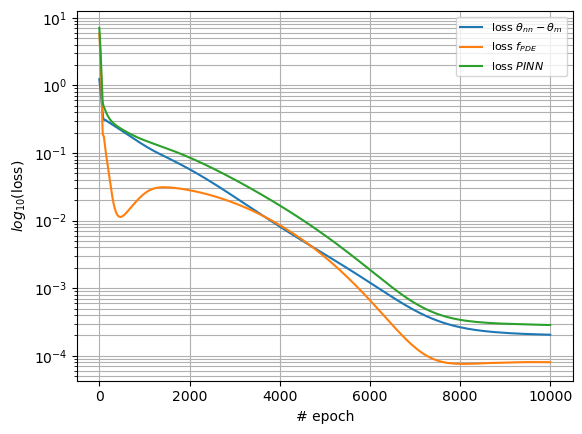

In [17]:
plt.cla()
plt.plot(range(steps),loss_theta, label = r'loss $\theta_{nn} - \theta_{m}$')
plt.plot(range(steps),loss_f, label = r'loss $f_{PDE}$')
plt.plot(range(steps),loss_hist, label = r'loss $PINN$')
# plt.plot(range(steps),loss_theta + loss_f)

plt.legend(loc='upper right', prop={'size': 8})
plt.xlabel('# epoch')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
# plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()

## PDE Parameters ($G$, $N$, $\epsilon_c$, $\epsilon_g$) value vs num epochs

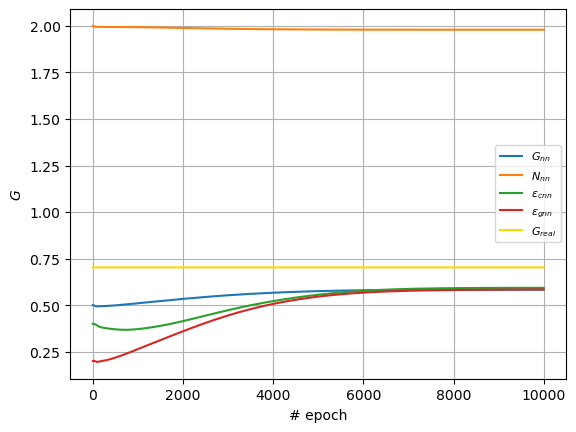

In [18]:
plt.cla()
plt.plot(range(steps), G_hist, label = r'$G_{nn}$')
plt.plot(range(steps), N_hist, label = r'$N_{nn}$')
plt.plot(range(steps), ec_hist, label = r'$\epsilon_{cnn}$')
plt.plot(range(steps), eg_hist, label = r'$\epsilon_{gnn}$')

plt.plot(range(steps), G_real*np.ones((steps,1)), label = r'$G_{real}$', color = 'gold')
plt.legend(loc='best', prop={'size': 8})
plt.xlabel('# epoch')
plt.ylabel(r'$G$')
plt.grid(True, which="both", ls="-")


##  Plot $\theta(x)$ solution

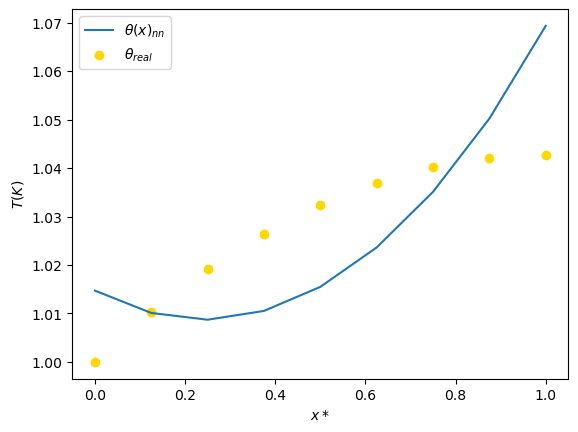

In [39]:
# compute theta values
x_u = X_real
theta_real = Theta_real.to('cpu').detach().numpy()
x_f = X_train_f.to('cpu').detach().numpy()
theta_nn = pinn.forward(X_train_f).to('cpu').detach().numpy()

# plt.cla()
plt.plot(x_f, theta_nn, label = r'$\theta(x)_{nn}$')
plt.scatter(x_u, theta_real, label = r'$\theta_{real}$', color = 'gold')

plt.xlabel('$x*$')
plt.ylabel('$T(K)$')
plt.legend(loc='upper left', prop={'size': 10})
